# Gaussian Process for Event likelihoods

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions

## Creating some random data

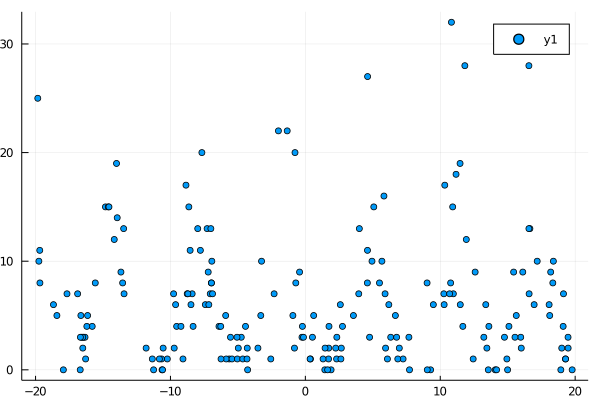

In [2]:
n_data = 200
X = (rand(n_data) .- 0.5) * 40
r = 5.0
Y = rand.(NegativeBinomial.(r, AGP.logistic.(sin.(X))))
scatter(X, Y)

## Run GP model with negative binomial likelihood to learn p

In [3]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_negbinomial = VGP(
    X, Y, kernel, NegBinomialLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_negbinomial, 20)

[ Info: Starting training Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and n_latent latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:02
  iter:  20
  ELBO:  -563.8466332122746
[ Info: Training ended after 20 iterations. Total number of iterations 20
  3.386796 seconds (7.46 M allocations: 475.199 MiB, 98.00% compilation time)


(Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference , (local_vars = (c = [0.5205396426139324, 0.37885102624689565, 0.4555950904957658, 0.536948880725714, 0.27648056703014195, 0.520652098395869, 0.4385045258047152, 0.16230730509315305, 0.23592269791176243, 0.30815000838553547  …  0.4325567796407531, 0.6916137636855993, 0.19581608412711565, 0.22038376570421855, 0.46874273113923326, 0.38338361653117714, 0.36256431083065926, 0.29264697311021215, 0.34999127249029083, 0.6025077627281119], θ = [3.423053831351671, 8.893876830775085, 16.22039771780696, 2.929940692414648, 5.962069170628168, 3.4230214583257665, 3.937113537413774, 2.9934313882640944, 4.976936893230769, 2.976484165827909  …  2.954082606209663, 2.4048945965414688, 4.485675944513538, 2.9879164342375533, 5.892501464793679, 5.927572870967726, 6.429720062594297, 5.957542453512232, 5.939494106883261, 13.105907461675402]), opt_state = (NamedTuple(),), hyperopt_state = (Name

## Running the same model but with a Poisson likelihood

In [4]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_poisson = VGP(
    X, Y, kernel, PoissonLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_poisson, 20)

[ Info: Starting training Variational Gaussian Process with a Poisson Likelihood (λ = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and n_latent latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:01
  iter:  20
  ELBO:  -726.2351281151871
[ Info: Training ended after 20 iterations. Total number of iterations 20
  2.294535 seconds (4.39 M allocations: 310.062 MiB, 11.21% gc time, 96.59% compilation time)


(Variational Gaussian Process with a Poisson Likelihood (λ = 13.709281536226534) infered by Analytic Variational Inference , (local_vars = (c = [0.7178203327936971, 0.3010479477395952, 0.4108098590774305, 0.7080492397323209, 0.17107285129970923, 0.7199709697186977, 0.643260636007226, 0.1978997503524408, 0.3340600391676808, 0.23341095709146428  …  0.6352777007850292, 0.875758672265257, 0.1683814987284587, 0.14295212437579988, 0.4310267527983151, 0.30742176506902585, 0.27737255008633466, 0.39431736971455655, 0.2651983132197092, 0.5901554293513757], θ = [5.328659119028923, 9.377686756711167, 16.537139878071308, 4.840661072984102, 6.704116959233596, 5.340245385717416, 5.7559819846707745, 4.139268388639839, 6.29656403612273, 3.7642983984233016  …  4.766462450309365, 4.48739235997679, 5.530866764769481, 3.922915537006688, 6.1293297976870775, 6.473322458460812, 6.977185317280376, 7.320732818714543, 6.556700956065146, 13.103032680046168], γ = [9.111048803481657, 5.896809762778295, 5.5381243352

Prediction and plot function on a grid
Create a grid and compute prediction on it

In [5]:
function compute_grid(model, n_grid=50)
    mins = -20
    maxs = 20
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, reshape(x_grid, :, 1)) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end

compute_grid (generic function with 2 methods)

Plot the data as a scatter plot

In [6]:
function plot_data(X, Y)
    return Plots.scatter(X, Y; alpha=0.33, msw=0.0, lab="", size=(800, 500))
end

function plot_model(model, X, Y, title=nothing)
    n_grid = 100
    y_grid, sig_y_grid, x_grid = compute_grid(model, n_grid)
    p = plot_data(X, Y)
    Plots.plot!(
        p,
        x_grid,
        y_grid;
        ribbon=2 * sqrt.(sig_y_grid), # Plot 2 std deviations
        title=title,
        color="red",
        lab="",
        linewidth=3.0,
    )
    return p
end;

## Comparison between the two likelihoods

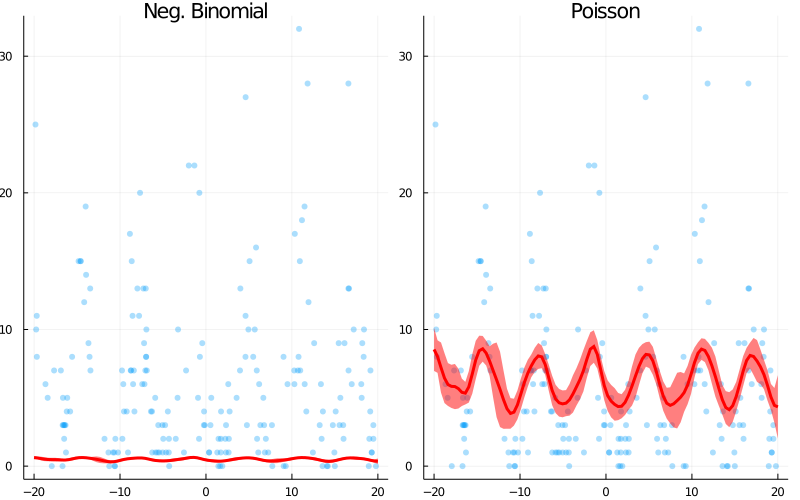

In [7]:
Plots.plot(
    plot_model.(
        [m_negbinomial, m_poisson], Ref(X), Ref(Y), ["Neg. Binomial", "Poisson"]
    )...;
    layout=(1, 2),
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*